# Maturité dentaire

In [80]:
# imports
import pandas as pd 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.decomposition import PCA

On sépare notre target de notre dataset, les features qui ont été sélectionnées pour le dropna sont celles qui ont le plus d'importance dans un modèle Random Forest non paramétré.

In [81]:
df = pd.read_csv('data/Teeth/dataset.csv', sep=';', dtype={'ID':'int','VAL_I1':'category','VAL_I2':'category','VAL_C1':'category','VAL_PM1':'category','VAL_PM2':'category','VAL_M1':'category','VAL_M2':'category','VAL_M3':'category'})
df.replace({'A':2,'B':3,'C':4,'D':5,'E':6,'F':7,'G':8,'H':9}, inplace=True)
df.dropna(inplace=True, subset=['VAL_PM1','VAL_PM2','VAL_M2'])
X = df.drop(['ID', 'PAT_AGE'], axis=1)
Y = df['PAT_AGE']

Transformations sur le dataset:
- KNNImputer avec 40 neighbors en prenant en compte les NaN
- PCA pour supprimer les outliers (après plusieurs test la suppression des 10% les plus faibles est la méthode optimale)

In [82]:
imp = KNNImputer(n_neighbors=40, add_indicator=True)
X = imp.fit_transform(X)
pca = PCA(n_components = 4, random_state=1)
pca_dataset = pca.fit_transform(X)
inverse_transform_dataset = pca.inverse_transform(pca_dataset)
MSE_score = ((X-inverse_transform_dataset)**2).sum(axis=1)
ids = int(0.1*len(MSE_score))
to_remove = MSE_score.argsort()[:ids]
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)
X.drop(X.index[to_remove], inplace=True)
Y.drop(Y.index[to_remove], inplace=True)
Y = np.ravel(Y)

Split du dataset

In [83]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=1)
print('X_train (shape) : {}'.format(X_train.shape))    
print('X_test (shape) : {}'.format(X_test.shape))    
print('Y_train (shape) : {}'.format(Y_train.shape))    
print('Y_test (shape) : {}'.format(Y_test.shape))    

X_train (shape) : (1771, 14)
X_test (shape) : (443, 14)
Y_train (shape) : (1771,)
Y_test (shape) : (443,)


### Random Forest
On commence par effectuer un random forest pour évaluer la qualité de notre preprocessing.
Après quelques GridSearch on obtient les paramètres suivants:

In [84]:
# à optimiser avec les params du gridsearch
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
reg = RandomForestRegressor(max_depth=7, n_estimators=56, random_state=1)
reg.fit(X_train, Y_train)
print('results:')
print('mae: {:2.5}'.format(mean_absolute_error(reg.predict(X_test), Y_test)))
print('mse: {:2.5}'.format(mean_squared_error(reg.predict(X_test), Y_test)))

results:
mae: 0.90693
mse: 1.6229


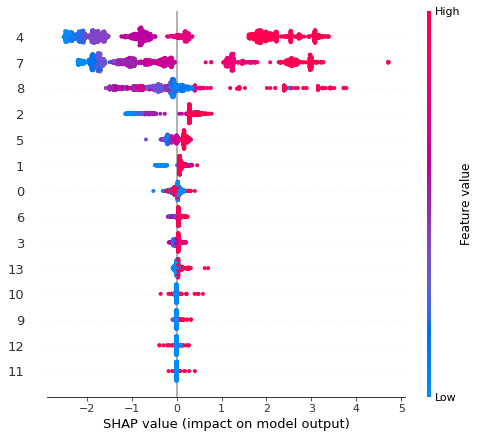

In [85]:
# aperçu de notre modèle
import shap
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

On a des bons résultats pour un simple Random Forest

### XGBoost

In [86]:
# à optimiser avec les params du gridsearch
import xgboost as xgb 
reg = xgb.XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=1, n_estimators=167, nthread=-1,
              objective='reg:linear', reg_alpha=1, reg_lambda=1,
              scale_pos_weight=1, seed=1, silent=True, subsample=0.8)
reg.fit(X_train, Y_train)
print('results:')
print('mae: {:2.5}'.format(mean_absolute_error(reg.predict(X_test), Y_test)))
print('mse: {:2.5}'.format(mean_squared_error(reg.predict(X_test), Y_test)))

[22:15:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[22:15:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


results:
mae: 0.88623
mse: 1.5751


### LGBM

In [87]:
from lightgbm import LGBMRegressor
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.001,
    "max_depth": 4,
    "n_estimators": 100,
    "num_iterations": 100000,
    "random_state":1
}
gbm = LGBMRegressor(**hyper_params)
gbm.fit(X_train, Y_train,
        eval_set=[(X_test, Y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)
print('results:')
print('mae: {:2.5}'.format(mean_absolute_error(gbm.predict(X_test), Y_test)))
print('mse: {:2.5}'.format(mean_squared_error(gbm.predict(X_test), Y_test)))

[1]	valid_0's l1: 3.55569	valid_0's l2: 18.8242
[2]	valid_0's l1: 3.55238	valid_0's l2: 18.7902
[3]	valid_0's l1: 3.54908	valid_0's l2: 18.7562
[4]	valid_0's l1: 3.54578	valid_0's l2: 18.7223
[5]	valid_0's l1: 3.54248	valid_0's l2: 18.6885
[6]	valid_0's l1: 3.53919	valid_0's l2: 18.6548
[7]	valid_0's l1: 3.53589	valid_0's l2: 18.6211
[8]	valid_0's l1: 3.53261	valid_0's l2: 18.5875
[9]	valid_0's l1: 3.52933	valid_0's l2: 18.5539
[10]	valid_0's l1: 3.52605	valid_0's l2: 18.5205
[11]	valid_0's l1: 3.52278	valid_0's l2: 18.487


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
Found `num_iterations` in params. Will use it instead of argument


[12]	valid_0's l1: 3.51951	valid_0's l2: 18.4537
[13]	valid_0's l1: 3.51624	valid_0's l2: 18.4204
[14]	valid_0's l1: 3.51298	valid_0's l2: 18.3872
[15]	valid_0's l1: 3.50972	valid_0's l2: 18.3541
[16]	valid_0's l1: 3.50646	valid_0's l2: 18.321
[17]	valid_0's l1: 3.50321	valid_0's l2: 18.288
[18]	valid_0's l1: 3.49996	valid_0's l2: 18.2551
[19]	valid_0's l1: 3.49672	valid_0's l2: 18.2222
[20]	valid_0's l1: 3.49347	valid_0's l2: 18.1894
[21]	valid_0's l1: 3.49023	valid_0's l2: 18.1566
[22]	valid_0's l1: 3.487	valid_0's l2: 18.124
[23]	valid_0's l1: 3.48376	valid_0's l2: 18.0913
[24]	valid_0's l1: 3.48053	valid_0's l2: 18.0588
[25]	valid_0's l1: 3.47733	valid_0's l2: 18.0264
[26]	valid_0's l1: 3.47411	valid_0's l2: 17.994
[27]	valid_0's l1: 3.47092	valid_0's l2: 17.9617
[28]	valid_0's l1: 3.4677	valid_0's l2: 17.9295
[29]	valid_0's l1: 3.46452	valid_0's l2: 17.8973
[30]	valid_0's l1: 3.46131	valid_0's l2: 17.8652
[31]	valid_0's l1: 3.45813	valid_0's l2: 17.8332
[32]	valid_0's l1: 3.45493	

### Réseau de neuronnes

In [88]:
import tensorflow as tf
keras = tf.keras
reg = keras.regularizers.l2(0.01)

model3 = keras.models.Sequential([
    keras.layers.Input(shape=X_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal", kernel_regularizer =reg),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal", kernel_regularizer =reg),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal", kernel_regularizer =reg),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1)
])
optimiser = keras.optimizers.Adam(lr=0.001)
model3.compile(loss="mae", optimizer=optimiser, metrics=["mae"])
model3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_32 (Batc (None, 14)                56        
_________________________________________________________________
dense_32 (Dense)             (None, 100)               1500      
_________________________________________________________________
dropout_22 (Dropout)         (None, 100)               0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 100)               400       
_________________________________________________________________
dense_33 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_23 (Dropout)         (None, 100)               0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 100)              

The `lr` argument is deprecated, use `learning_rate` instead.


In [89]:
checkpoint = keras.callbacks.ModelCheckpoint("save/model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)

model3_history = model3.fit(X_train, Y_train, epochs=500, batch_size=16,
                                validation_split=0.1, callbacks=[checkpoint, early_stopping])

Epoch 1/500
100/100 [==============================] - 3s 9ms/step - loss: 14.3384 - mae: 10.1753 - val_loss: 10.3474 - val_mae: 7.4783
Epoch 2/500
100/100 [==============================] - 0s 5ms/step - loss: 8.3225 - mae: 5.9172 - val_loss: 4.0296 - val_mae: 1.8598
Epoch 3/500
100/100 [==============================] - 0s 4ms/step - loss: 4.5877 - mae: 2.5131 - val_loss: 3.3385 - val_mae: 1.3558
Epoch 4/500
100/100 [==============================] - 0s 4ms/step - loss: 3.9297 - mae: 2.0279 - val_loss: 3.0876 - val_mae: 1.2663
Epoch 5/500
100/100 [==============================] - 0s 4ms/step - loss: 3.7141 - mae: 1.9701 - val_loss: 3.0138 - val_mae: 1.3477
Epoch 6/500
100/100 [==============================] - 0s 4ms/step - loss: 3.5240 - mae: 1.9280 - val_loss: 2.8793 - val_mae: 1.3530
Epoch 7/500
100/100 [==============================] - 1s 5ms/step - loss: 3.2817 - mae: 1.8195 - val_loss: 2.7478 - val_mae: 1.3500
Epoch 8/500
100/100 [==============================] - 0s 5ms/step

In [90]:
print('results:')
print('mae: {:2.5}'.format(mean_absolute_error(model3.predict(X_test), Y_test)))
print('mse: {:2.5}'.format(mean_squared_error(model3.predict(X_test), Y_test)))

results:
mae: 0.95382
mse: 1.8148
